In [1]:
import os, sys
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# PYTORCH APPROACH

#### Custom dataset

In [2]:
from torch.utils.data import Dataset

In [3]:
class ROOT_dataset(Dataset):
    '''
        This class is used to:
            - read a root file;
            - get all relevant histograms in the root file and convert them to 1d numpy arrays;
            - read the csv file with labels corresponding to the histograms;
            - match the 1d numpy arrays with the labels;
            - return the matched data as a dataset.
        Input: 
            - annotation_file: the csv file with the labels;
            - root_file: the root file with histograms;
        Output:
            - pytorch dataset ready to be used for the training of a neural network.
    '''
    def __init__(self, annotation_file, path_to_root_file, histtype='hist_0'):
        self.root_annotated = pd.read_csv(annotation_file)
        self.root_file, self.all_histtype_keys = self.read_root(path_to_root_file, histtype=histtype)
        self.histtype = histtype
        self.listCHN = self.root_annotated['#Ch.#'].tolist()
        # self.primary_target_cols = ['t', 'E(t)', 'A_0', 'E(A_0)', 't_p', 'E(t_p)', 'k3', 'E(k3)', 'k4', 'E(k4)', 'k5', 'E(k5)', 'k6', 'E(k6)', 'Chi2/DOF']
        self.primary_target_cols = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def __len__(self):
        return len(self.root_annotated)

    def __getitem__(self, channelNumber):
        histname = '_'.join([self.histtype, 'channel', f'{channelNumber};1'])
        hist = self.get_histogram(root_data=self.root_file, histname=histname)
        if channelNumber in self.listCHN:
            target = self.root_annotated.loc[self.root_annotated['#Ch.#']==channelNumber][self.primary_target_cols]
            return hist, target.values
        else:
            return hist, None
    
    def read_root(self, filename, histtype='hist_0', filetype='rawdata'):
        root_file = uproot.open(filename)
        print(len(root_file.keys()))
        all_histtype_keys = []
        for key in root_file.keys():
            if ('RawData' not in key) and ('FitResults' not in key):
                if histtype in key:
                    all_histtype_keys.append(key)
        return root_file, all_histtype_keys

    def get_histogram(self, root_data, histname):
        TH1D_hist = root_data[histname].to_numpy()
        return TH1D_hist

In [4]:
dataset = ROOT_dataset(annotation_file='data/run_30413/run_30413_labelled.csv', path_to_root_file='raw_waveforms_run_30413.root', histtype='hist_0')
dataset.__getitem__(channelNumber=29)


33927


((array([ 6.000e+00,  1.100e+01,  1.400e+01,  1.900e+01,  2.200e+01,
          2.300e+01,  1.800e+01,  1.400e+01,  9.000e+00,  2.000e+00,
          7.100e+01,  1.196e+03,  3.741e+03,  6.197e+03,  7.224e+03,
          6.631e+03,  5.053e+03,  3.269e+03,  1.786e+03,  7.820e+02,
          2.280e+02, -1.400e+01, -8.400e+01, -8.100e+01, -4.700e+01,
         -1.300e+01,  1.600e+01,  4.300e+01,  5.700e+01,  5.900e+01,
          6.200e+01,  6.400e+01,  6.500e+01,  6.500e+01,  7.000e+01,
          7.300e+01,  7.400e+01,  7.300e+01,  6.900e+01,  6.300e+01,
          5.600e+01,  4.900e+01,  4.000e+01,  3.400e+01,  3.300e+01,
          2.900e+01,  2.800e+01,  3.200e+01,  4.000e+01,  4.600e+01,
          4.700e+01,  4.400e+01,  3.800e+01,  3.600e+01,  4.100e+01,
          4.500e+01,  4.500e+01,  4.300e+01,  4.500e+01,  5.100e+01,
          5.900e+01,  6.600e+01,  6.400e+01,  5.600e+01,  4.800e+01,
          4.900e+01,  5.100e+01,  5.300e+01,  4.900e+01,  3.900e+01,
          2.800e+01,  3.200e+01,  

In [5]:
hist, target = dataset.__getitem__(channelNumber=20)

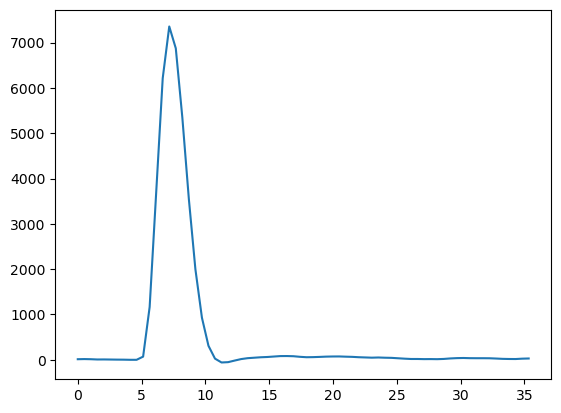

In [6]:
plt.figure()
plt.plot(hist[1][:70], hist[0][:70])
plt.show()

In [7]:
pd.DataFrame(target, columns=dataset.primary_target_cols)

,t,A_0,t_p,k3,k4,k5,k6
0,5.036479,79272.01603,2.14184,0.477705,0.567924,0.120598,0.107032


In [9]:
from torch.utils.data import DataLoader
dataset = ROOT_dataset(
    annotation_file='data/run_30413/run_30413_labelled.csv', 
    path_to_root_file='raw_waveforms_run_30413.root',
    histtype='hist_0'
)

batch_size = 16
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

33927


In [8]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [202]:
import torch
from torch import nn
import torch.nn.functional as F

class EncoderWF(nn.Module):
    def __init__(self, input_channels=2, hidden_dims=(32, 64, 128), kernel_size=3, stride=1):
        pass

In [203]:
dataset[0][0][0].shape

(331,)

# Generating the waveforms using the fit parameters (simulation)

In [9]:
from response import *

In [365]:
class Sim_waveform:
    def __init__(self, path_to_sim=None, output_path=None):
        self.path_to_sim = path_to_sim
        self.output_path = output_path
        self.sim_data = pd.DataFrame()
        if self.path_to_sim is not None:
            self.sim_data = self.read_csv_sim()
        self.response_params = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def read_csv_sim(self):
        tmpdata = pd.read_csv(self.path_to_sim)
        cols = list(tmpdata.columns)
        cols_to_be_removed = [c for c in cols if 'Unnamed' in c]
        tmpdata.drop(labels=cols_to_be_removed, axis=1, inplace=True)
        tmpdata['#Ch.#'] = tmpdata['#Ch.#'].astype('int32')
        return tmpdata
    
    def __generate_1wf(self, params=None):
        if params is None:
            return None
        x = np.linspace(params[0], params[0]+70, 70)
        R = response(x=x, par=params)
        return R
    
    def run(self):
        # N_samples = self.sim_data.shape[0]
        N_samples = 10000
        key_name = self.path_to_sim.split('/')[-1].split('.')[0].split('_')[3]
        for isample in range(N_samples):
            params = list(self.sim_data[self.response_params].iloc[isample])
            R = self.__generate_1wf(params=params)
            dict_params = dict(zip(self.response_params, params))
            dict_params['class'] = self.sim_data['class'].iloc[isample]
            dict_params['wf'] = R
            dict_params['integral_R'] = self.sim_data['integral_R'].iloc[isample]
            dict_params['max_deviation'] = self.sim_data['max_deviation'].iloc[isample]
            np.savez(f'{self.output_path}/wf_{key_name}_{isample}.npz', **dict_params)


In [366]:
sim_wf_obj = Sim_waveform(path_to_sim='data/labelledData/labelledData/generated_new_samples_c3_labelled_tails.csv',
                          output_path='data/labelledData/labelledData/WF_sim/')
sim_wf_obj.run()

# BDT approach

**The dataset we want to use are the numpy files npz which might require a large memory. For that reason, we want to load them chunk by chunk and train the model using chunks.**

In [367]:
import xgboost as xgb

In [411]:
class Load_chunk_dset:
    '''
        This class will load a chunk of the data.
    '''
    def __init__(self, path_to_dset: str, chunk_size=5, target_columns=['']):
        self.path_to_dset = path_to_dset
        self.list_dset = ['/'.join([self.path_to_dset, f]) for f in os.listdir(self.path_to_dset)[:5000]]
        self.target_columns = target_columns
        self.input_columns = [f'p{i}' for i in range(70)]
        self.chunk_size = chunk_size
        self.iter = 0

    def npz2df(self, filepath='', forTest_regressor=False):
        data = np.load(filepath)
        wf = np.array(data['wf']).reshape(-1, 1)
        wf_dict = {f'p{i}': wf[i] for i in range(len(wf))}
        keys = [c for c in list(data.keys()) if c!='wf']
        for k in keys:
            wf_dict[k] = np.array(data[k].flatten())
        wf_df = pd.DataFrame(wf_dict)

        if forTest_regressor:
            # split features (input) and target values
            y = wf_df[self.target_columns]
            X = wf_df[self.input_columns].values
            return xgb.DMatrix(X, label=None), y
        else:
            return wf_df

    def reset(self):
        self.iter = 0
        return self
    
    def load(self):
        try:
            chunk = pd.DataFrame()
            if self.chunk_size*(self.iter+1) > len(self.list_dset)-1:
                return None
            for i, ichunk in enumerate(range(self.iter*self.chunk_size, (self.iter+1)*self.chunk_size)):
                df = self.npz2df(filepath=self.list_dset[ichunk])
                if i==0:
                    chunk = df.copy()
                else:
                    chunk = pd.concat([chunk, df], axis=0)
            if len(chunk)==0:
                return None
            self.iter += 1
            
            # split features (input) and target values
            y = chunk[self.target_columns].values
            X = chunk[self.input_columns].values

            return xgb.DMatrix(X, label=y)
        except:
            return None
    
        
class PreClassifier_BDT:
    '''
        Given a waveform as input, this class will:
            - predict the fit parameters
            - classify them into four classes c1, c2, c3, c4
        using a boosted decision tree.
        Inputs:
            path_to_data: path to the dataset used for training the regression and classification models.
                        This dataset located at this path should be a numpy dataset (npz) which contains the wf datapoints,
                        the fit parameters ('t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6'), and the corresponding class ('class').
            output_path : path to where the output will be saved.
    '''
    def __init__(self, path_to_data=None, output_path=None, target_columns=['']):
        '''
            path_to_data : path to the list of npz data,
            output_path : path to where you want to save the output of the code.
        '''
        self.path_to_data = path_to_data
        self.output_path = output_path
        self.target_columns = target_columns


    def regression(self):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric' : 'rmse',
            'max_depth': 15,
            'learning_rate': 0.4,
            'min_child_weight' : 15,
            'num_boost_round': 200,
            'subsample': 1.0,
            'colsample_bytree': 1.0
        }

        data_iter = Load_chunk_dset(path_to_dset=self.path_to_data, chunk_size=200, target_columns=self.target_columns)
        next_chunk = data_iter.load()
        eval_chunk = data_iter.load()
        regressor_model = xgb.train(params=params,
                                    dtrain = next_chunk,
                                    evals=[(next_chunk, 'train'), (eval_chunk, 'eval')],
                                    early_stopping_rounds=20,
                                    xgb_model=None,
                                    verbose_eval=True)
        next_chunk = data_iter.load()
        eval_chunk = data_iter.load()
        while (next_chunk is not None) and (eval_chunk is not None):
            regressor_model = xgb.train(params=params,
                                        dtrain = next_chunk,
                                        xgb_model = regressor_model,
                                        evals=[(next_chunk, 'train'), (eval_chunk, 'eval')],
                                        early_stopping_rounds=20,
                                        verbose_eval=True)
            next_chunk = data_iter.load()
            eval_chunk = data_iter.load()
        return regressor_model
    
    def testRegressor(self, regressor_predFitParams=None, regressor_predIntegral=None, regressor_predMaxdev=None, Ntest=100):
        if regressor_predFitParams is None:
            return None
        
        if regressor_predIntegral is None:
            return None
        
        if regressor_predMaxdev is None:
            return None
        
        list_dset = ['/'.join([self.path_to_data, f]) for f in os.listdir(self.path_to_data)[5000:5000+Ntest]]
        target_columns = self.target_columns + ['integral_R', 'max_deviation']
        data_iter = Load_chunk_dset(path_to_dset=self.path_to_data, chunk_size=0, target_columns=target_columns)
        
        # load the regression model trained to predict the value of the integral
        regressor_predIntegral_model = xgb.Booster()
        regressor_predIntegral_model.load_model(regressor_predIntegral)

        # load the regression model trained to predict the value of the maximum deviation between tails
        regressor_predMaxdev_model = xgb.Booster()
        regressor_predMaxdev_model.load_model(regressor_predMaxdev)

        comparison_df = pd.DataFrame()
        for j, f in enumerate(list_dset):
            dtest, ytest = data_iter.npz2df(filepath=f, forTest_regressor=True)
            # predict the fit parameters using the waveform as input
            predictions = regressor_predFitParams.predict(dtest)
            pred_df = pd.DataFrame({f'{self.target_columns[i]}': predictions.reshape(-1,1)[i] for i in range(len(self.target_columns))})
            
            # predict the integral of the tail using the fit parameters as input
            ytest_fitparams = ytest[['A_0', 't_p', 'k3', 'k4', 'k5', 'k6']]
            ytest_dmatrix = xgb.DMatrix(ytest_fitparams, label=None)
            #
            # prediction of integral using truth information
            pred_integral_ofTruth = regressor_predIntegral_model.predict(ytest_dmatrix)
            # prediction of integral using predicted fit parameters
            ypred_dmatrix = xgb.DMatrix(pred_df[['A_0', 't_p', 'k3', 'k4', 'k5', 'k6']], label=None)
            pred_integral_ofPred = regressor_predIntegral_model.predict(ypred_dmatrix)
            #
            # prediction of the max deviation using the true information
            pred_maxdev_ofTruth = regressor_predMaxdev_model.predict(ytest_dmatrix)
            # prediction of the max deviation using the predicted fit parameters
            pred_maxdev_ofPred = regressor_predMaxdev_model.predict(ypred_dmatrix)

            # print('\n')
            # print(pred_integral[0], ytest['integral_R'].iloc[0])

            cols = [f'{c}_pred' for c in pred_df.columns]
            pred_df.columns = cols
            cols = [f'{c}_truth' for c in ytest_fitparams.columns]
            ytest_fitparams.columns = cols

            # concatenate
            pred_df = pd.concat([ytest_fitparams, pred_df], axis=1)
            # integral
            pred_df['integral_R_truth_truth'] = [ytest['integral_R'].iloc[0]]
            pred_df['integral_R_truth_pred'] = pred_integral_ofTruth
            pred_df['integral_R_pred_pred'] = pred_integral_ofPred
            # max deviation
            pred_df['max_deviation_truth_truth'] = [ytest['max_deviation'].iloc[0]]
            pred_df['max_deviation_truth_pred'] = pred_maxdev_ofTruth
            pred_df['max_deviation_pred_pred'] = pred_maxdev_ofPred
            
            if j==0:
                comparison_df = pred_df.copy()
            else:
                comparison_df = pd.concat([comparison_df, pred_df.copy()], axis=0)

        return comparison_df
        
    def classification(self):
        pass
    

In [415]:
target_columns = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']
# target_columns = ['class']
# chunk_dset_obj = Load_chunk_dset(path_to_dset='data/labelledData/labelledData/WF_sim', chunk_size=5, target_columns=taget_columns)
# chunk_dset_obj.test()
preclassifier_obj = PreClassifier_BDT(path_to_data='data/labelledData/labelledData/WF_sim', output_path='OUTPUT/Preclassifier', target_columns=target_columns)
regressor_model = preclassifier_obj.regression()
test_df = preclassifier_obj.testRegressor(regressor_predFitParams=regressor_model, Ntest=5000, regressor_predIntegral='OUTPUT/Kept_RESULTS/OK_SIMULATION_moreSamplesThanApr12_2025/integral_R_model.json',
                                          regressor_predMaxdev='OUTPUT/Kept_RESULTS/OK_SIMULATION_moreSamplesThanApr12_2025/max_deviation_model.json')

[0]	train-rmse:16119.92564	eval-rmse:17031.34370
[1]	train-rmse:9962.41010	eval-rmse:10788.72484
[2]	train-rmse:6225.94597	eval-rmse:7032.13147
[3]	train-rmse:3972.98679	eval-rmse:4727.50953
[4]	train-rmse:2634.96524	eval-rmse:3433.88786
[5]	train-rmse:1864.83599	eval-rmse:2787.91004
[6]	train-rmse:1434.80564	eval-rmse:2404.45012
[7]	train-rmse:1178.29117	eval-rmse:2196.59831
[8]	train-rmse:1039.91759	eval-rmse:2126.15475
[9]	train-rmse:915.79732	eval-rmse:2048.17282


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1766.05293	eval-rmse:1998.94535
[1]	train-rmse:1588.15166	eval-rmse:1973.39024
[2]	train-rmse:1462.68708	eval-rmse:1948.99456
[3]	train-rmse:1377.21914	eval-rmse:1946.63928
[4]	train-rmse:1302.65050	eval-rmse:1986.33687
[5]	train-rmse:1190.75014	eval-rmse:1964.18513
[6]	train-rmse:1109.76762	eval-rmse:1898.58787
[7]	train-rmse:1033.57527	eval-rmse:1947.72142
[8]	train-rmse:974.35933	eval-rmse:1912.43977
[9]	train-rmse:900.39775	eval-rmse:1901.97819


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1573.33642	eval-rmse:1935.59463
[1]	train-rmse:1397.84234	eval-rmse:1899.09780
[2]	train-rmse:1258.25110	eval-rmse:1904.96298
[3]	train-rmse:1187.71245	eval-rmse:1905.39602
[4]	train-rmse:1099.86558	eval-rmse:1920.50215
[5]	train-rmse:1047.93036	eval-rmse:1961.21424
[6]	train-rmse:991.33188	eval-rmse:1958.62995
[7]	train-rmse:937.10315	eval-rmse:1979.80467
[8]	train-rmse:889.35334	eval-rmse:1982.86054
[9]	train-rmse:845.55439	eval-rmse:2022.85283


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1529.50362	eval-rmse:2048.74268
[1]	train-rmse:1377.89744	eval-rmse:2024.93835
[2]	train-rmse:1288.58054	eval-rmse:2019.71119
[3]	train-rmse:1207.79055	eval-rmse:2035.93513
[4]	train-rmse:1131.11311	eval-rmse:2012.98903
[5]	train-rmse:1067.04494	eval-rmse:2015.79916
[6]	train-rmse:1002.40671	eval-rmse:2034.03603
[7]	train-rmse:924.21075	eval-rmse:2030.86801
[8]	train-rmse:875.01892	eval-rmse:2018.35580
[9]	train-rmse:836.76050	eval-rmse:2028.49354


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1647.06897	eval-rmse:1889.32585
[1]	train-rmse:1504.58823	eval-rmse:1867.08399
[2]	train-rmse:1409.14800	eval-rmse:1896.17771
[3]	train-rmse:1320.61648	eval-rmse:1906.82706
[4]	train-rmse:1244.30450	eval-rmse:1925.36300
[5]	train-rmse:1170.62037	eval-rmse:1957.66422
[6]	train-rmse:1113.64519	eval-rmse:1927.65859
[7]	train-rmse:1052.42363	eval-rmse:1924.94955
[8]	train-rmse:988.02000	eval-rmse:1890.60968
[9]	train-rmse:941.57863	eval-rmse:1922.00940


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1398.04376	eval-rmse:1532.37125
[1]	train-rmse:1245.65699	eval-rmse:1552.28758
[2]	train-rmse:1159.62659	eval-rmse:1589.27238
[3]	train-rmse:1067.36053	eval-rmse:1593.85712
[4]	train-rmse:1018.74537	eval-rmse:1607.96981
[5]	train-rmse:966.35226	eval-rmse:1618.59019
[6]	train-rmse:921.72997	eval-rmse:1626.84775
[7]	train-rmse:881.59217	eval-rmse:1632.98354
[8]	train-rmse:834.16092	eval-rmse:1646.22524
[9]	train-rmse:801.29421	eval-rmse:1642.89586


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1517.04937	eval-rmse:1864.15787
[1]	train-rmse:1401.34077	eval-rmse:1883.43052
[2]	train-rmse:1282.88563	eval-rmse:1860.37992
[3]	train-rmse:1194.28243	eval-rmse:1877.00966
[4]	train-rmse:1120.09975	eval-rmse:1859.26802
[5]	train-rmse:1049.05895	eval-rmse:1811.55150
[6]	train-rmse:979.18596	eval-rmse:1794.82000
[7]	train-rmse:923.05983	eval-rmse:1786.80121
[8]	train-rmse:878.73004	eval-rmse:1778.11783
[9]	train-rmse:824.57929	eval-rmse:1765.19468


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1504.55014	eval-rmse:1585.12175
[1]	train-rmse:1330.70741	eval-rmse:1600.54735
[2]	train-rmse:1204.70850	eval-rmse:1631.46027
[3]	train-rmse:1106.35581	eval-rmse:1599.57270
[4]	train-rmse:1024.74708	eval-rmse:1611.17917
[5]	train-rmse:940.68828	eval-rmse:1625.20134
[6]	train-rmse:874.27813	eval-rmse:1626.52823
[7]	train-rmse:824.43551	eval-rmse:1617.37993
[8]	train-rmse:767.92013	eval-rmse:1621.05310
[9]	train-rmse:723.25092	eval-rmse:1619.83687


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1536.98205	eval-rmse:2040.17506
[1]	train-rmse:1391.30350	eval-rmse:2064.67379
[2]	train-rmse:1235.83728	eval-rmse:2066.34643
[3]	train-rmse:1147.49561	eval-rmse:2088.59563
[4]	train-rmse:1052.01473	eval-rmse:2109.29109
[5]	train-rmse:977.60508	eval-rmse:2115.98838
[6]	train-rmse:905.65295	eval-rmse:2139.59522
[7]	train-rmse:851.13658	eval-rmse:2143.89444
[8]	train-rmse:789.26139	eval-rmse:2147.54563
[9]	train-rmse:756.47567	eval-rmse:2154.15323


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1537.07733	eval-rmse:1718.91976
[1]	train-rmse:1400.92557	eval-rmse:1740.73302
[2]	train-rmse:1309.95385	eval-rmse:1778.47621
[3]	train-rmse:1216.88201	eval-rmse:1780.39279
[4]	train-rmse:1150.44883	eval-rmse:1779.84642
[5]	train-rmse:1059.70298	eval-rmse:1797.09996
[6]	train-rmse:993.11502	eval-rmse:1801.62015
[7]	train-rmse:941.45241	eval-rmse:1796.81026
[8]	train-rmse:883.75114	eval-rmse:1799.54244
[9]	train-rmse:836.57489	eval-rmse:1799.61630


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1507.80054	eval-rmse:1799.17866
[1]	train-rmse:1389.93680	eval-rmse:1774.00021
[2]	train-rmse:1268.41728	eval-rmse:1776.30442
[3]	train-rmse:1171.49847	eval-rmse:1772.84619
[4]	train-rmse:1072.65006	eval-rmse:1806.09577
[5]	train-rmse:1008.51392	eval-rmse:1800.18101
[6]	train-rmse:952.59277	eval-rmse:1801.64851
[7]	train-rmse:898.16828	eval-rmse:1796.99335
[8]	train-rmse:849.12454	eval-rmse:1797.83676
[9]	train-rmse:808.18842	eval-rmse:1793.87564


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1546.02151	eval-rmse:1827.68400
[1]	train-rmse:1409.61120	eval-rmse:1804.13913
[2]	train-rmse:1318.88427	eval-rmse:1818.30803
[3]	train-rmse:1230.49432	eval-rmse:1828.31079
[4]	train-rmse:1127.99272	eval-rmse:1834.79931
[5]	train-rmse:1080.08919	eval-rmse:1848.84921
[6]	train-rmse:1015.88894	eval-rmse:1835.25194
[7]	train-rmse:948.67715	eval-rmse:1819.33260
[8]	train-rmse:887.88533	eval-rmse:1840.01890
[9]	train-rmse:847.76775	eval-rmse:1845.42926


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:30:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [417]:
test_df

,A_0_truth,t_p_truth,k3_truth,k4_truth,k5_truth,k6_truth,t_pred,A_0_pred,t_p_pred,k3_pred,k4_pred,k5_pred,k6_pred,integral_R_truth_truth,integral_R_truth_pred,integral_R_pred_pred,max_deviation_truth_truth,max_deviation_truth_pred,max_deviation_pred_pred
0,53200.740635,2.138715,2.046020,2.297054,2.147225,2.368100,5.034164,52557.558594,2.126082,2.528389,2.341707,1.589275,1.941794,0.812889,0.714454,0.714454,-0.358399,-0.370075,-0.412992
0,96477.306245,2.169562,1.829866,1.766138,1.699356,2.006320,5.117599,103417.976562,2.167469,2.184402,2.383229,1.990431,2.169898,1.269180,0.981621,0.981621,-0.359464,-0.679725,-0.428173
0,43646.312146,2.235714,1.242431,1.626596,0.673659,0.672288,4.882874,42886.984375,2.261396,1.412500,1.712486,0.320330,0.804129,0.228830,5.854925,-197.898773,-0.744610,0.843370,-91.238274
0,58421.218382,2.173418,1.448008,1.800858,1.975424,1.858420,4.965526,64034.789062,2.171405,0.758165,1.837857,2.570699,1.692739,0.428049,0.714454,-11.506542,-0.533433,-0.506283,-8.138809
0,85957.509779,2.126353,1.493626,1.499256,1.698516,1.898732,4.991099,82973.257812,2.118035,1.900355,2.028479,1.986681,2.001120,0.782633,0.981621,0.981621,-1.240977,-0.844867,-0.544622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,54959.477023,2.110209,1.991832,2.473900,2.052389,2.051957,5.147140,56502.867188,2.087489,1.999271,1.828569,2.549676,2.424762,0.909306,0.714454,0.714454,-0.321588,-0.412992,-0.488295
0,53300.860129,2.273029,1.731812,2.272429,2.080852,1.953567,4.816887,52160.199219,2.268324,1.909157,2.717057,1.228830,2.206676,0.980913,0.714454,0.714454,-0.252854,-0.316884,-0.691176
0,68194.009885,2.038165,2.281102,2.437008,2.551046,2.824505,5.133712,69466.000000,2.026172,2.475730,2.108449,2.398494,2.415641,1.312630,0.714454,0.714454,-0.161833,-0.360584,-0.360584
0,95942.162908,2.228223,1.941551,2.188696,1.946898,2.068484,5.039967,98923.382812,2.237725,2.521118,2.703129,2.147079,1.100730,1.680404,0.981621,0.981621,-0.329908,-0.398399,-0.310142


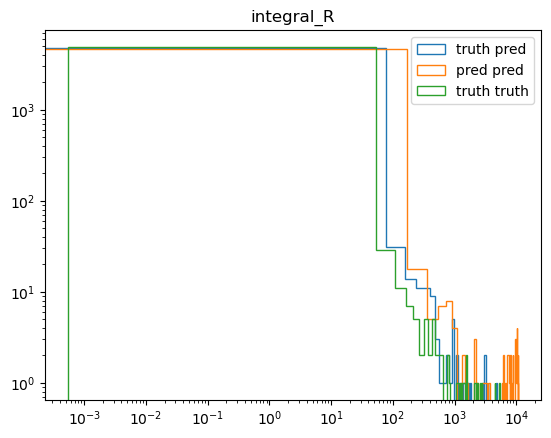

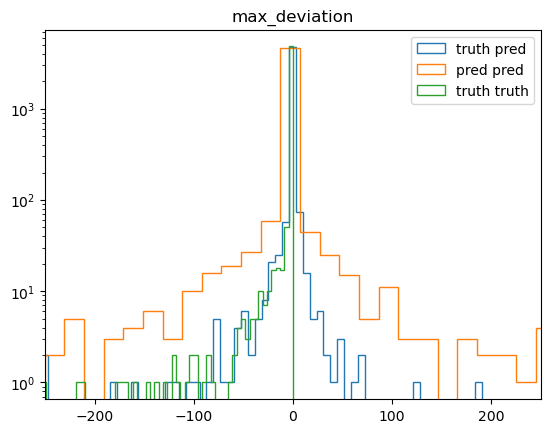

In [423]:
param = 'integral_R'
plt.figure()
plt.hist(test_df[f'{param}_truth_pred'], histtype='step', bins=100, label='truth pred')
plt.hist(test_df[f'{param}_pred_pred'], histtype='step', bins=100, label='pred pred')
plt.hist(test_df[f'{param}_truth_truth'], histtype='step', bins=100, label='truth truth')
plt.title(param)
# plt.xlim([-2000, 2000])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
#
param = 'max_deviation'
plt.figure()
plt.hist(test_df[f'{param}_truth_pred'], histtype='step', bins=100, label='truth pred')
plt.hist(test_df[f'{param}_pred_pred'], histtype='step', bins=100, label='pred pred')
plt.hist(test_df[f'{param}_truth_truth'], histtype='step', bins=100, label='truth truth')
plt.title(param)
plt.xlim([-250, 250])
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()